# Lesson 5: Supervised Learning - Identifying Rig State (Sliding vs Rotating)

# ------------------------------
# 📚 SECTION 1: Welcome & Framing
# ------------------------------

Welcome to Lesson 6! 🎉

Last time we used synthetic data in our slide/rotate identification example. 

Today we're going to use the real drilling data set from the Forge 16A.

We'll start with an Unsupervised data to apply initial labeling, then train a Supervised model on those labels.

We'll finish with an evaluation of different types of Supervised ML Models.

# ------------------------------
# 📚 SECTION 2: Load & Transform Data
# ------------------------------

## Today we're using real drilling data from Forge 16 A. Let's load the drilling dataset.

### Bring in Forge drilling data

In [60]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#check the current working directory
# print(os.getcwd())
# os.chdir("..")

file_path = "c:\\Users\\RDavis\\Desktop\\Github\\python-for-drilling-engineers\\module_5\\slide_rotate_runs_df.csv"
df = pd.read_csv(file_path)

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/python-for-drilling-engineers/module_6/slide_rotate_runs_df.csv'

df = pd.read_csv(file_path)

## Calculated Features

We'll create some rolling averages & rolling standard deviations in order to better train our model.


In [61]:
#set the rig time to a datetime object
df['rig_time'] = pd.to_datetime(df['rig_time'], format='%Y-%m-%d %H:%M:%S')
df['rig_time_delta'] = df['rig_time'].diff()
df['rig_time_delta'] = df['rig_time_delta'].fillna(0)
df['rig_time_delta'] = pd.to_timedelta(df['rig_time_delta'])
print(df['rig_time_delta'].dtype)
# convert the rig time delta to seconds
df['rig_time_delta'] = df['rig_time_delta'].dt.total_seconds()
avg_freq = df['rig_time_delta'].median()
print(f"Average frequency: {avg_freq:.2f} seconds")
# df['td_rpm_rolling_mean']

timedelta64[ns]
Average frequency: 10.00 seconds


Calculate RPM & TQ Rolling Avg per minute.
Calculate RPM & TQ Rolling Standard Deviation per minute.

In order to do this we will use the `.rolling()` function from Pandas.
Based on the average frequency of our data we will use a window=6.

In [ ]:
window_size = 6
df['td_rpm_rolling_mean'] = df['td_rpm'].rolling(window=window_size).mean()
df['td_rpm_rolling_mean'] = df['td_rpm_rolling_mean'].fillna(0)
df['td_rpm_rolling_stdv'] = df['td_rpm'].rolling(window=window_size).std()
df['td_rpm_rolling_stdv'] = df['td_rpm_rolling_stdv'].fillna(0)
df['td_torque_rolling_mean'] = df['td_torque'].rolling(window=window_size).mean()
df['td_torque_rolling_mean'] = df['td_torque_rolling_mean'].fillna(0)
df['td_torque_rolling_stdv'] = df['td_torque'].rolling(window=window_size).std()
df['td_torque_rolling_stdv'] = df['td_torque_rolling_stdv'].fillna(0)
df['td_rpm_rolling_mean'] = df['td_rpm_rolling_mean'].astype(float)
df['td_rpm_rolling_stdv'] = df['td_rpm_rolling_stdv'].astype(float)
df['td_torque_rolling_mean'] = df['td_torque_rolling_mean'].astype(float)
df['td_torque_rolling_stdv'] = df['td_torque_rolling_stdv'].astype(float)

# ------------------------------
# 📚 SECTION 3: Unsupervised Model
# ------------------------------

Let's use an unsupervised model to apply some starting labels.

**Feature Selection:**
This is where your domain expertise can be put to good use:
- Select features that you know will provide clear distinctions between the operations you are trying to identify.
- Which data do you look to identify if you're sliding or rotating?

rop
0


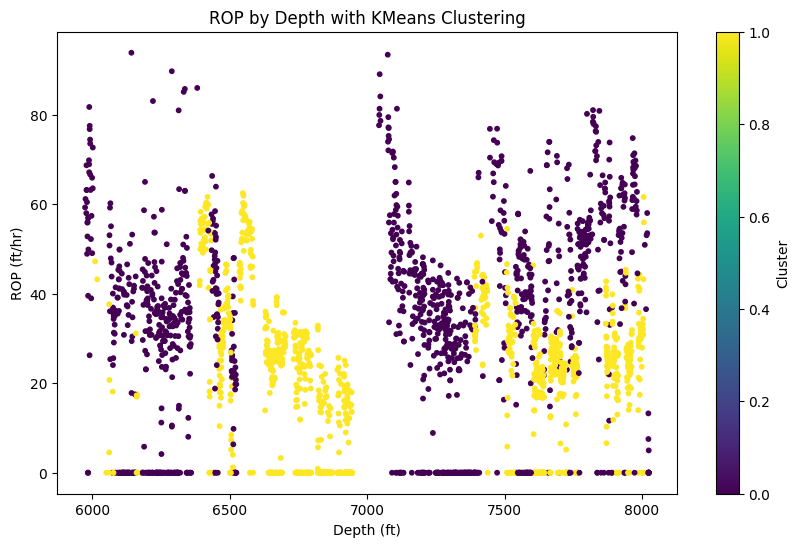

In [ ]:

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Select features and perform clustering
# features = df[['rop',
#                'wob',
#                'td_rpm',
#                'td_torque']]

features = df[['rop',
               'wob',
               'td_rpm',
               'td_torque',
               'td_rpm_rolling_mean',
               'td_torque_rolling_mean',
               'td_rpm_rolling_stdv',
               'td_torque_rolling_stdv']]

df.dropna(subset=features.columns, inplace=True)
print(features.columns[0])
print(len(df[df[features.columns[3]].isna()]))
# Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
# Perform KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=0)
df['Cluster'] = kmeans.fit_predict(scaled_features)

sampled = df.sample(3000)
plt.figure(figsize=(10, 6))
plt.scatter(sampled['md'], sampled['rop'], c=sampled['Cluster'], cmap='viridis', s=10)
plt.xlabel('Depth (ft)')
plt.ylabel('ROP (ft/hr)')
plt.title('ROP by Depth with KMeans Clustering')
plt.colorbar(label='Cluster')
plt.show()


### Visualize the Clusters & Features

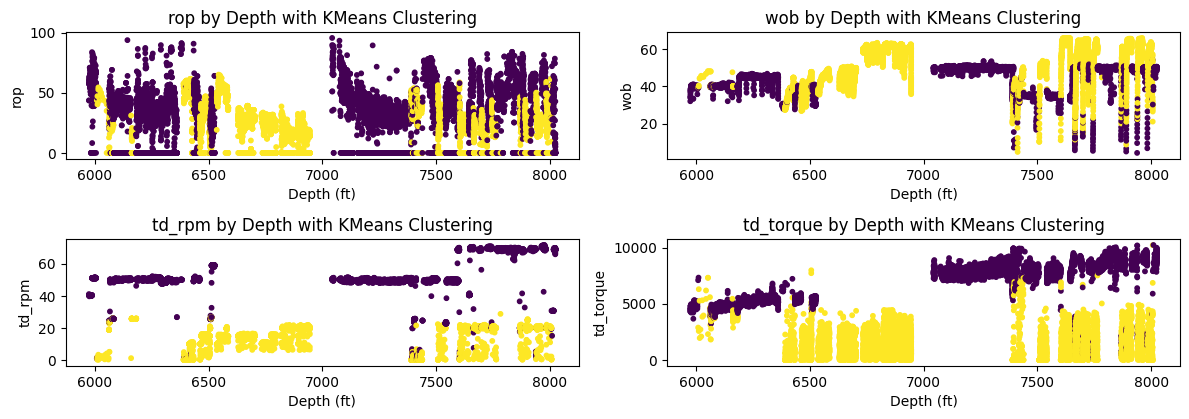

In [108]:
# Visualize subplot with shared x-axis of 'md' and plots with the y-axis being each of the 4 items in features.columns
plt.figure(figsize=(12, 8))
for i, col in enumerate(features.columns):
    plt.subplot(4, 2, i + 1)
    plt.scatter(df['md'], df[col], c=df['Cluster'], cmap='viridis', s=10)
    plt.xlabel('Depth (ft)')
    plt.ylabel(col)
    plt.title(f'{col} by Depth with KMeans Clustering')
plt.tight_layout()
plt.show()

### Visualize Sensor Data by Cluster

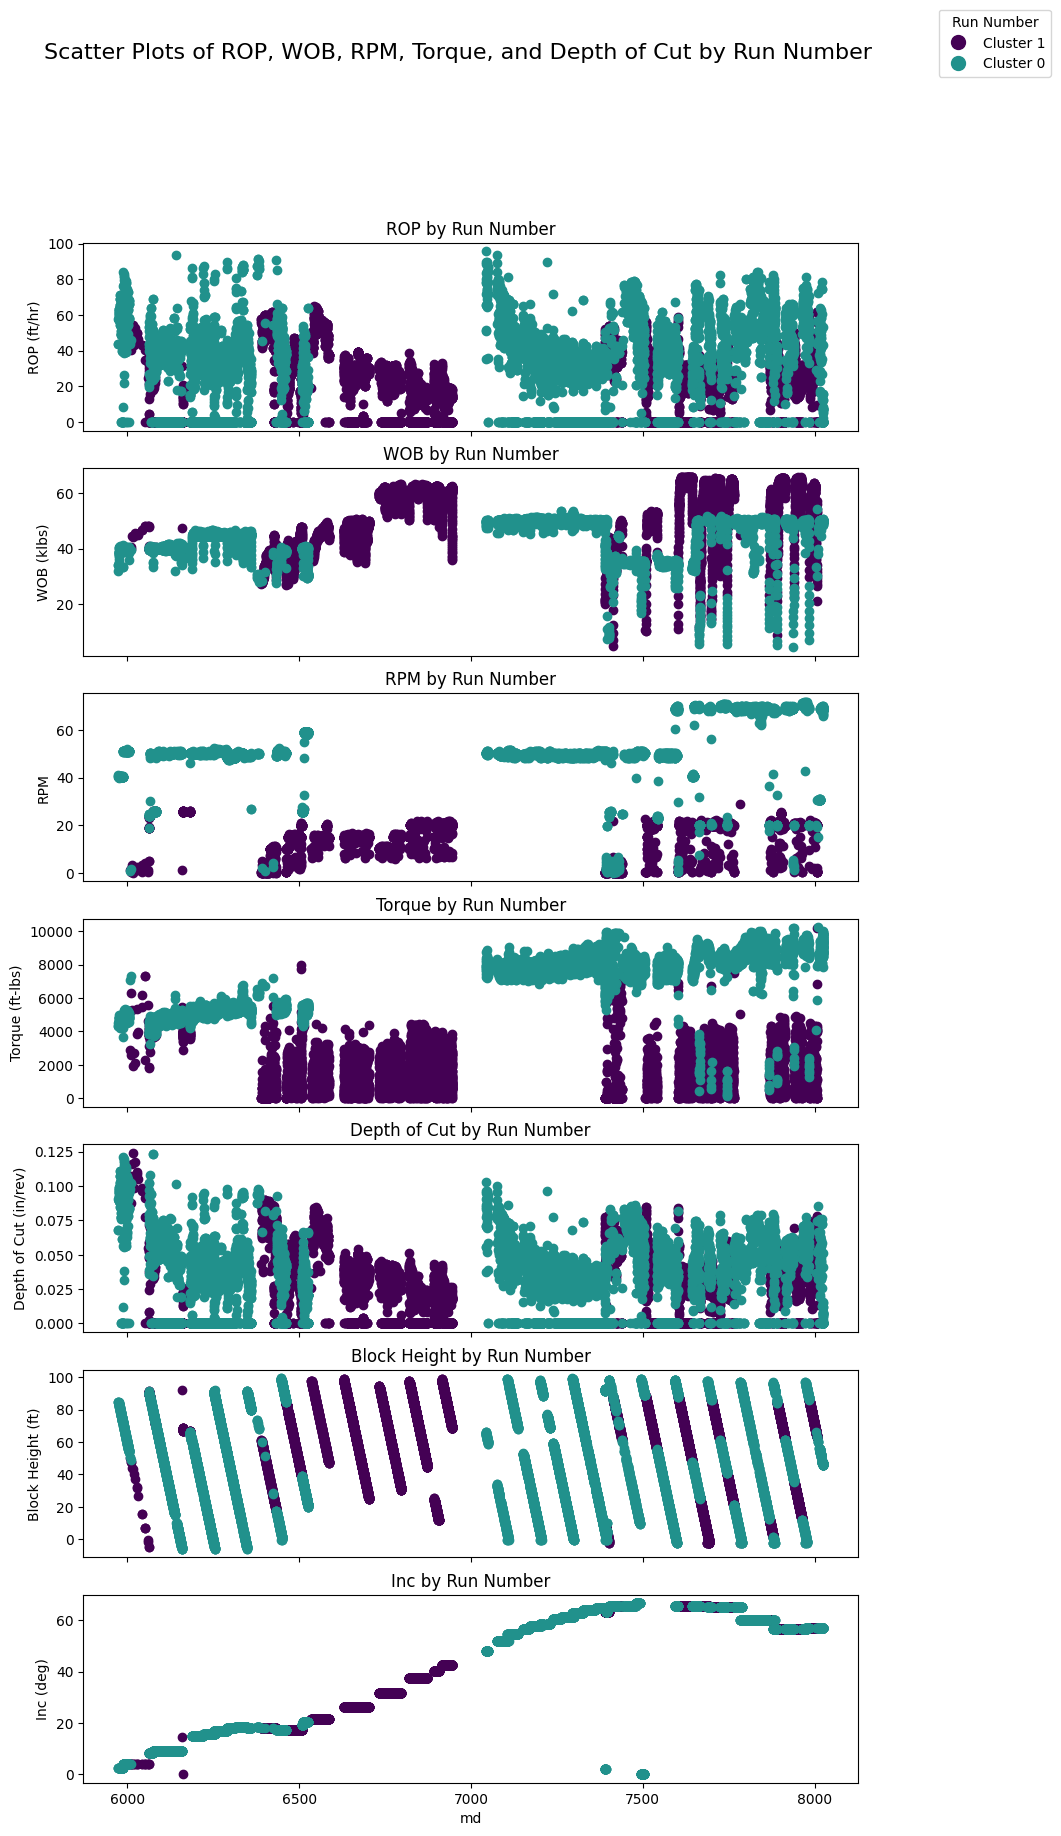

In [109]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


fig, axs = plt.subplots(7, 1, figsize=(10, 20), sharex=True)
fig.suptitle('Scatter Plots of ROP, WOB, RPM, Torque, and Depth of Cut by Run Number', fontsize=16)

# Iterate through clusters and plot each with its specific color
for cluster in cluster_list:
    cluster_df = df[df['Cluster'] == cluster]
    color = color_map_dict[cluster]
    axs[0].scatter(cluster_df['md'], cluster_df['rop'], color=color, label=f'Cluster {cluster}')
    axs[1].scatter(cluster_df['md'], cluster_df['wob'], color=color)
    axs[2].scatter(cluster_df['md'], cluster_df['td_rpm'], color=color)
    axs[3].scatter(cluster_df['md'], cluster_df['td_torque'], color=color)
    axs[4].scatter(cluster_df['md'], cluster_df['depth_of_cut'], color=color)
    axs[5].scatter(cluster_df['md'], cluster_df['block_height'], color=color)
    axs[6].scatter(cluster_df['md'], cluster_df['inc'], color=color)

# Set labels and titles
axs[0].set_ylabel('ROP (ft/hr)')
axs[0].set_title('ROP by Run Number')
axs[1].set_ylabel('WOB (klbs)')
axs[1].set_title('WOB by Run Number')
axs[2].set_ylabel('RPM')
axs[2].set_title('RPM by Run Number')
axs[3].set_ylabel('Torque (ft-lbs)')
axs[3].set_title('Torque by Run Number')
axs[4].set_ylabel('Depth of Cut (in/rev)')
axs[4].set_title('Depth of Cut by Run Number')
axs[5].set_ylabel('Block Height (ft)')
axs[5].set_title('Block Height by Run Number')
axs[6].set_ylabel('Inc (deg)')
axs[6].set_xlabel('md')
axs[6].set_title('Inc by Run Number')

# Build legend
handles = [Line2D([0], [0], marker='o', color=color_map_dict[cluster], markersize=10, linestyle='') 
           for cluster in cluster_list]
labels = [f'Cluster {cluster}' for cluster in cluster_list]
fig.legend(handles, labels, title='Run Number', loc='upper right', bbox_to_anchor=(1.1, 1))


### Automate RigState Labels

In [70]:
group_df = df.groupby('Cluster').agg({
    'rop': ['mean', 'std'],
    'wob': ['mean', 'std'],
    'td_rpm': ['mean', 'std'],
    'td_torque': ['mean', 'std']}).reset_index().rename(columns={'index': 'Cluster'})
group_df

Cluster        rop                   wob                td_rpm            \
                mean        std       mean        std       mean       std   
0       0  31.009243  23.242150  44.900370   5.938230  52.774909  8.956068   
1       1  19.697786  16.531521  53.399975  11.035353  16.493304  6.392104   

     td_torque               
          mean          std  
0  7015.061931  1571.615862  
1  1491.113507  1386.091959

In [71]:
# Identify which cluster is sliding and which is rotating
group_df = df.groupby('Cluster').agg(
    count=('run_number', 'size'),
    avg_rop=('rop', 'mean'),
    avg_wob=('wob', 'mean'),
    avg_td_rpm=('td_rpm', 'mean'),
    avg_td_torque=('td_torque', 'mean')
).reset_index()
print(group_df)
cluster_0_screen = (group_df['Cluster'] == 0)
cluster_1_screen = (group_df['Cluster'] == 1)
cluster_0_avg_rpm = group_df.loc[cluster_0_screen, 'avg_td_rpm']
cluster_1_avg_rpm = group_df.loc[cluster_1_screen, 'avg_td_rpm']
cluster_0_avg_torque = group_df.loc[cluster_0_screen, 'avg_td_torque']
cluster_1_avg_torque = group_df.loc[cluster_1_screen, 'avg_td_torque']
# Determine which cluster is sliding and which is rotating by the avg RPM and avg Torque (greater RPM and Torque is rotating)
if cluster_0_avg_rpm.mean() > cluster_1_avg_rpm.mean():
    sliding_cluster = 1
    rotating_cluster = 0
else:
    sliding_cluster = 0
    rotating_cluster = 1
# Add a new column to the df DataFrame to indicate the state
df['RigState'] = np.where(df['Cluster'] == sliding_cluster, 'Sliding', 'Rotating')

# Print which cluster is sliding and which is rotating
print(f"Sliding cluster: {sliding_cluster}")
print(f"Rotating cluster: {rotating_cluster}")
print('RigState added to the dataframe successfully.')

   Cluster  count    avg_rop    avg_wob  avg_td_rpm  avg_td_torque
0        0   8417  31.009243  44.900370   52.774909    7015.061931
1        1   9137  19.697786  53.399975   16.493304    1491.113507
Sliding cluster: 1
Rotating cluster: 0
RigState added to the dataframe successfully.


### Check to Ensure Label Application

Let's visualize the same charts to ensure our Rig State labels were applied correctly.

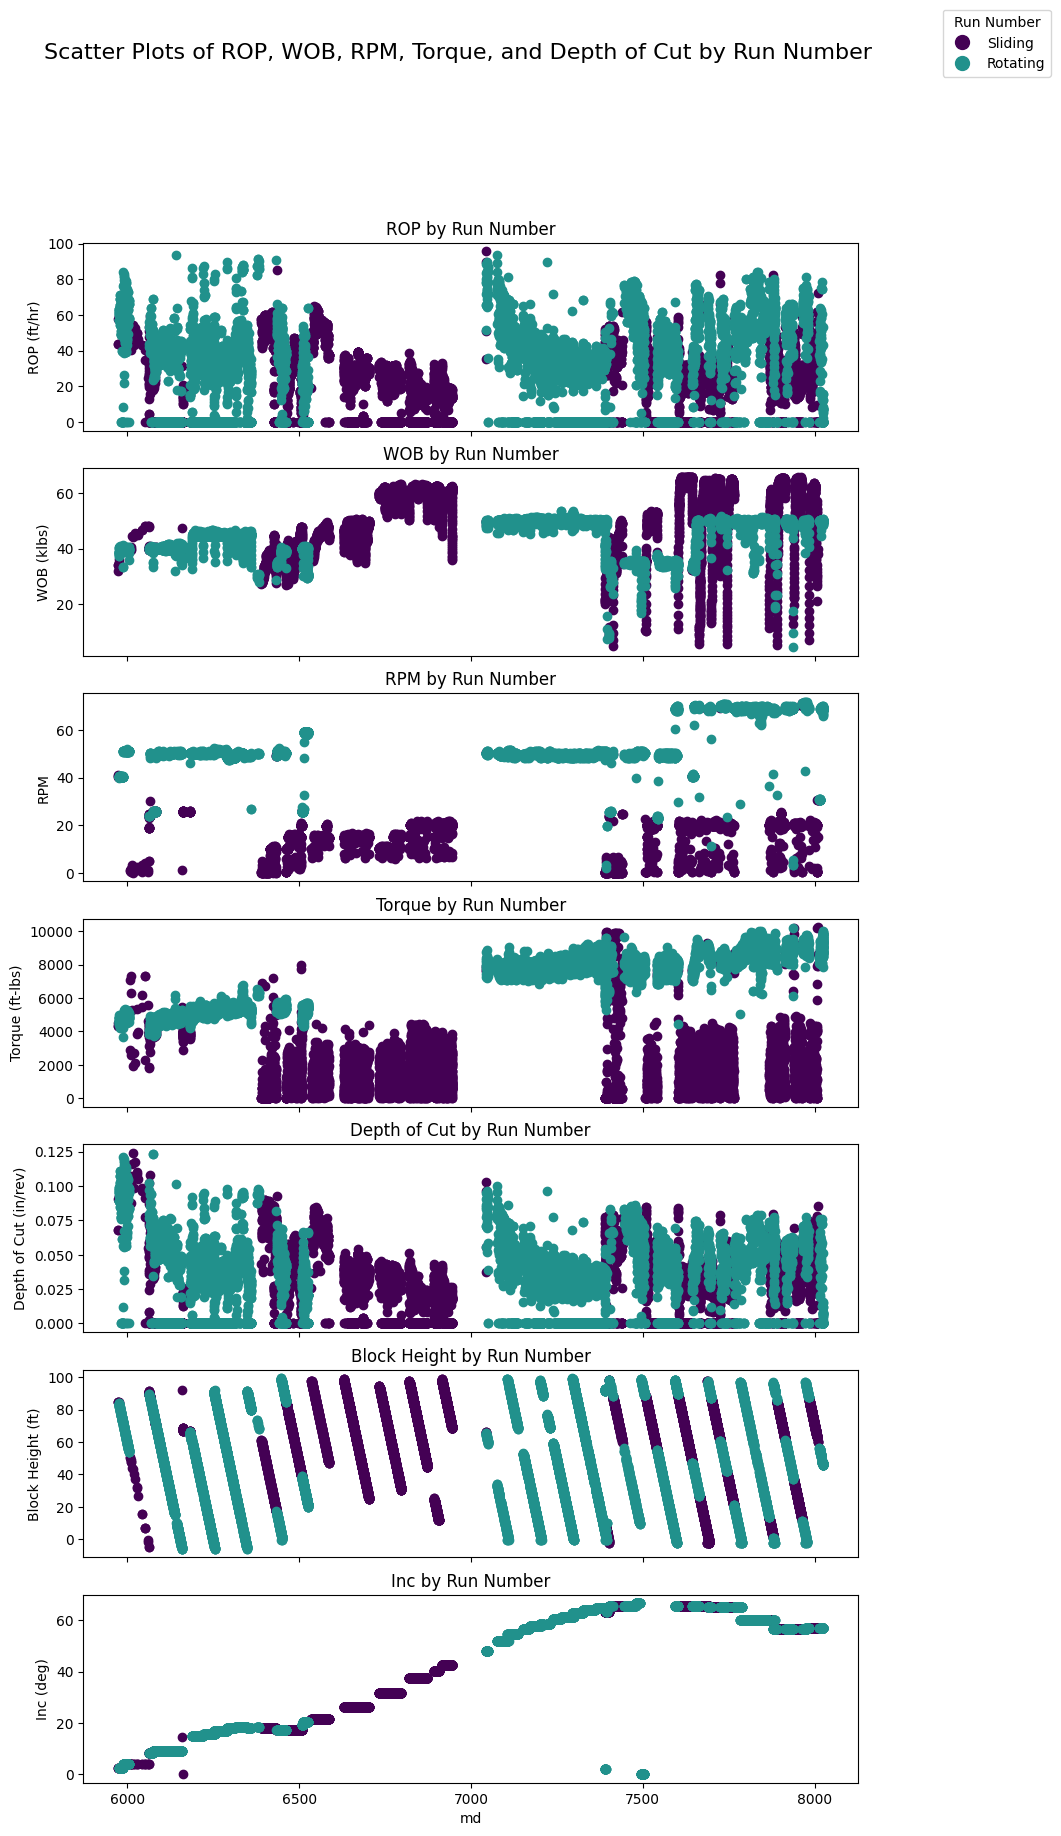

In [72]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
fig, axs = plt.subplots(7, 1, figsize=(10, 20), sharex=True)
fig.suptitle('Scatter Plots of ROP, WOB, RPM, Torque, and Depth of Cut by Run Number', fontsize=16)

# Iterate through clusters and plot each with its specific color
for cluster in cluster_list:
    cluster_df = df[df['Cluster'] == cluster]
    color = color_map_dict[cluster]
    axs[0].scatter(cluster_df['md'], cluster_df['rop'], color=color, label=f'Cluster {cluster}')
    axs[1].scatter(cluster_df['md'], cluster_df['wob'], color=color)
    axs[2].scatter(cluster_df['md'], cluster_df['td_rpm'], color=color)
    axs[3].scatter(cluster_df['md'], cluster_df['td_torque'], color=color)
    axs[4].scatter(cluster_df['md'], cluster_df['depth_of_cut'], color=color)
    axs[5].scatter(cluster_df['md'], cluster_df['block_height'], color=color)
    axs[6].scatter(cluster_df['md'], cluster_df['inc'], color=color)

# Set labels and titles
axs[0].set_ylabel('ROP (ft/hr)')
axs[0].set_title('ROP by Run Number')
axs[1].set_ylabel('WOB (klbs)')
axs[1].set_title('WOB by Run Number')
axs[2].set_ylabel('RPM')
axs[2].set_title('RPM by Run Number')
axs[3].set_ylabel('Torque (ft-lbs)')
axs[3].set_title('Torque by Run Number')
axs[4].set_ylabel('Depth of Cut (in/rev)')
axs[4].set_title('Depth of Cut by Run Number')
axs[5].set_ylabel('Block Height (ft)')
axs[5].set_title('Block Height by Run Number')
axs[6].set_ylabel('Inc (deg)')
axs[6].set_xlabel('md')
axs[6].set_title('Inc by Run Number')

# Build legend
handles = [Line2D([0], [0], marker='o', color=color_map_dict[cluster], markersize=10, linestyle='') 
           for cluster in cluster_list]
labels = ['Sliding' if cluster == sliding_cluster else 'Rotating' for cluster in cluster_list]
fig.legend(handles, labels, title='Run Number', loc='upper right', bbox_to_anchor=(1.1, 1))



In [111]:
filtered_df = df[df['rig_time_delta'] < 60]
filtered_df['hole_depth_delta'] = filtered_df['md'].diff()
filtered_df['hole_depth_delta'] = filtered_df['hole_depth_delta'].fillna(0)
groupby_df = filtered_df.groupby('RigState').agg(
    count=('run_number', 'size'),
    time=('rig_time_delta', 'sum'),
    depth=('hole_depth_delta', 'sum')
).reset_index()
groupby_df['time'] = groupby_df['time'].apply(lambda x: pd.to_timedelta(x, unit='s'))
groupby_df['time'] = groupby_df['time'].dt.total_seconds() / 3600  # Convert to hours
groupby_df['pct_time'] = groupby_df['time'] / groupby_df['time'].sum() * 100
groupby_df['pct_depth'] = groupby_df['depth'] / groupby_df['depth'].sum() * 100
groupby_df['time'] = groupby_df['time'].round(2)
print(groupby_df)

   RigState  count  time       depth   pct_time  pct_depth
0  Rotating   7568  5.21  1069.84678  47.579214  52.296962
1   Sliding   8232  5.74   975.86819  52.420786  47.703038


C:\Users\RDavis\AppData\Local\Temp\ipykernel_2836\3939099000.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['hole_depth_delta'] = filtered_df['md'].diff()
C:\Users\RDavis\AppData\Local\Temp\ipykernel_2836\3939099000.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['hole_depth_delta'] = filtered_df['hole_depth_delta'].fillna(0)


### Label Verification

Unsupervised models can cut down the time needed to label raw data. However, results should be verified by domain experts and corrected as needed.

# ------------------------------
# 📚 SECTION 4: Supervised Model
# ------------------------------

Now let's use the labels from the **Unsupervised model** to train a **Supervised Model**

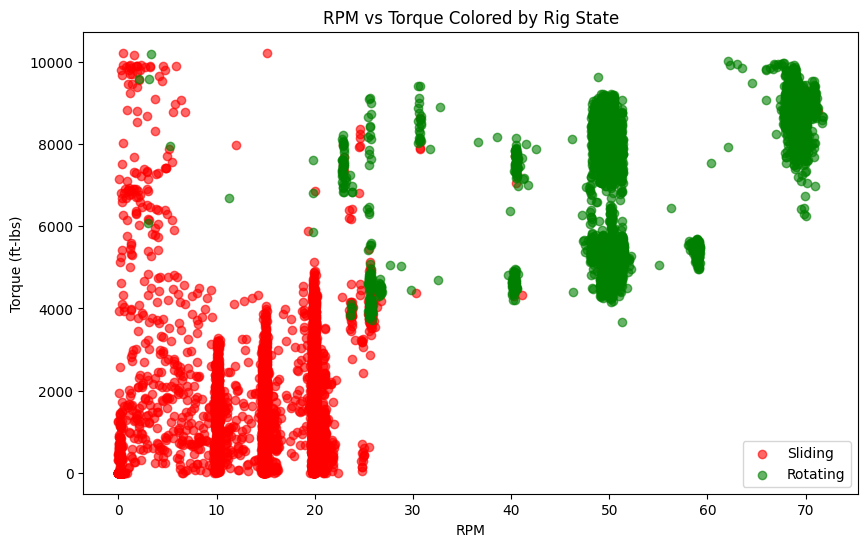

In [77]:
plt.figure(figsize=(10,6))
for label, color in zip([sliding_cluster, rotating_cluster], ['red', 'green']):
    subset = df[df['Cluster'] == label]
    plt.scatter(subset['td_rpm'], subset['td_torque'], c=color, label='Sliding' if label==sliding_cluster else 'Rotating', alpha=0.6)

plt.xlabel('RPM')
plt.ylabel('Torque (ft-lbs)')
plt.title('RPM vs Torque Colored by Rig State')
plt.legend()
plt.show()

### Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split

feature_columns = ['td_rpm', 'td_torque', 'td_rpm_rolling_mean', 'td_torque_rolling_mean', 'td_rpm_rolling_stdv', 'td_torque_rolling_stdv']

# Our features we're training the model on
X = df[feature_columns]
# Our target variable we're trying to predict ('Sliding', 'Rotating')
y = df['RigState']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")



Training samples: 14043, Testing samples: 3511


## Testing Multiple Models

| **Model**            | **When to Use**                            | **Pros**                            | **Cons**                          |
|---------------------|-------------------------------------------|------------------------------------|-----------------------------------|
| Logistic Regression   | Simple yes/no problems                    | Fast, easy, interpretable           | Only works with linear boundaries |
| Decision Tree         | Clear, rule-based splits                  | Explainable, flexible               | Can overfit small data            |
| Random Forest         | Noisy data, better accuracy needed        | Handles complexity, robust          | Slower, less transparent          |
| Support Vector Machine| Overlapping classes, complex boundaries   | Works well with hard-to-separate data| Hard to tune, less explainable    |
| Neural Networks       | Lots of data, complex non-linear patterns | Captures deep patterns              | Requires more compute, harder to interpret |

In [94]:
import time
# Install scikit-learn if running in Colab
try:
    import sklearn
except ImportError:
    !pip install scikit-learn

from sklearn.linear_model import LogisticRegression

logistic_regretion_model = LogisticRegression()
start_time = time.time()
logistic_regretion_model.fit(X_train, y_train)
train_time = time.time() - start_time
print(f"Training time: {train_time:.2f} seconds")

Training time: 0.19 seconds


c:\Users\RDavis\Desktop\Github\python-for-drilling-engineers\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [95]:
# Install scikit-learn if running in Colab
try:
    import sklearn
except ImportError:
    !pip install scikit-learn

from sklearn.ensemble import RandomForestClassifier

rand_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
start_time = time.time()
rand_forest_model.fit(X_train, y_train)
train_time = time.time() - start_time
print(f"Training time: {train_time:.2f} seconds")

Training time: 2.00 seconds


# ------------------------------
# 📚 SECTION 7: Evaluate Model
# ------------------------------

Last time we only looked at the accuracy and confusion matrix. This time we'll take a more in-depth look at model evaluation.

### 📊 Model Evaluation Metrics Summary

| **Metric**   | **What It Tells You**                            | **When to Trust It**                         |
|--------------|--------------------------------------------------|----------------------------------------------|
| Accuracy     | Overall correctness                              | When classes are balanced                    |
| Precision    | Correctness when predicting ‘Rotating’           | When false positives are costly              |
| Recall       | Coverage of actual ‘Rotating’ events             | When missing real events is costly           |
| F1 Score     | Balance between precision and recall             | When you want a single quality score         |
| ROC AUC      | Model’s ability to separate Sliding vs Rotating  | When comparing models across thresholds      |


In [100]:
start_time = time.time()
y_pred = logistic_regretion_model.predict(X_test)
run_time = time.time() - start_time
print(f"Prediction time: {run_time:.2f} seconds")

from sklearn.metrics import (accuracy_score, 
                             confusion_matrix,
                             precision_score,
                             recall_score,
                             f1_score,
                             roc_auc_score)


y_pred = logistic_regretion_model.predict(X_test)
y_proba = logistic_regretion_model.predict_proba(X_test)[:, 1]  # Needed for ROC AUC

# Metrics
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='Rotating')
recall = recall_score(y_test, y_pred, pos_label='Rotating')
f1 = f1_score(y_test, y_pred, pos_label='Rotating')

roc_auc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

# Print neatly
print("Logistic Regression Model Results:")
print("===================================")
print(f"Accuracy:  {acc:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")
print(f"ROC AUC:   {roc_auc:.2f}")
print("Confusion Matrix:")
print(cm)



Prediction time: 0.00 seconds
Logistic Regression Model Results:
Accuracy:  0.99
Precision: 0.99
Recall:    1.00
F1 Score:  0.99
ROC AUC:   1.00
Confusion Matrix:
[[1694    1]
 [  21 1795]]


In [101]:
start_time = time.time()
y_pred = rand_forest_model.predict(X_test)
run_time = time.time() - start_time
print(f"Prediction time: {run_time:.2f} seconds")

from sklearn.metrics import (accuracy_score, 
                             confusion_matrix,
                             precision_score,
                             recall_score,
                             f1_score,
                             roc_auc_score)


y_pred = rand_forest_model.predict(X_test)
y_proba = rand_forest_model.predict_proba(X_test)[:, 1]  # Needed for ROC AUC

# Metrics
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='Rotating')
recall = recall_score(y_test, y_pred, pos_label='Rotating')
f1 = f1_score(y_test, y_pred, pos_label='Rotating')

roc_auc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

# Print neatly
print('Random Forest Classifier Results:')
print("===================================")
print(f"Accuracy:  {acc:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")
print(f"ROC AUC:   {roc_auc:.2f}")
print("Confusion Matrix:")
print(cm)



Prediction time: 0.04 seconds
Random Forest Classifier Results:
Accuracy:  1.00
Precision: 1.00
Recall:    1.00
F1 Score:  1.00
ROC AUC:   1.00
Confusion Matrix:
[[1692    3]
 [   2 1814]]


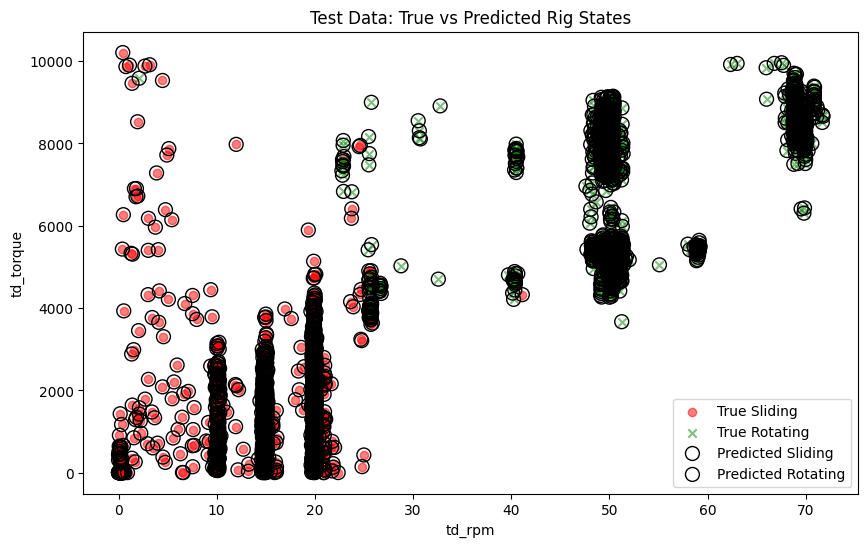

In [102]:
plt.figure(figsize=(10,6))

# Use string labels directly
for true_label, color, marker in zip(['Sliding', 'Rotating'], ['red', 'green'], ['o', 'x']):
    subset = X_test[y_test == true_label]
    plt.scatter(subset['td_rpm'], subset['td_torque'], 
                c=color, marker=marker, label=f"True {true_label}", alpha=0.5)

# Add predicted labels to a copy of X_test
preds = X_test.copy()
preds['Predicted'] = y_pred

for pred_label, edgecolor in zip(['Sliding', 'Rotating'], ['black', 'black']):
    subset = preds[preds['Predicted'] == pred_label]
    plt.scatter(subset['td_rpm'], subset['td_torque'], facecolors='none', edgecolors=edgecolor, 
                s=100, linewidths=1, label=f"Predicted {pred_label}")

plt.xlabel('td_rpm')
plt.ylabel('td_torque')
plt.legend()
plt.title('Test Data: True vs Predicted Rig States')
plt.show()
